In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import xlsxwriter
from PIL import Image
import os
from PIL.ExifTags import TAGS
import piexif
import random
from os import listdir
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
#read in excel files
xls18 = pd.ExcelFile('NHL 2017-18.xls')
season18 = pd.read_excel(xls18, 'TOT',header=2)
#xls17 = pd.ExcelFile('NHL 2016-17.xls')
#season17 = pd.read_excel(xls17, 'All Sits',header=2)
#shots=pd.read_csv("shots_2017.csv")

In [3]:
season18=season18[season18.columns[~
                        season18.columns.isin(["TOI.1","TOI.2","TOI.3","iCF.1","iCF.2","iFF.1","iHF.1","iPENT2",
                                            "iPENT5","iPEND2","iPEND5",'CF.1','CA.1','FF.1','FA.1','SF.1','SA.1'
                                            ,'GF.1','GA.1','GP.1', 'G.1', 'A.1', 'PTS.1', '+/-.1','PIM.1',
                                            'TOI.4', 'OPS.1', 'DPS.1', 'PS.1','A1'])]]

In [4]:
season18=season18[season18['Cap Hit']>1000000]
season18=season18.reset_index(drop=True)

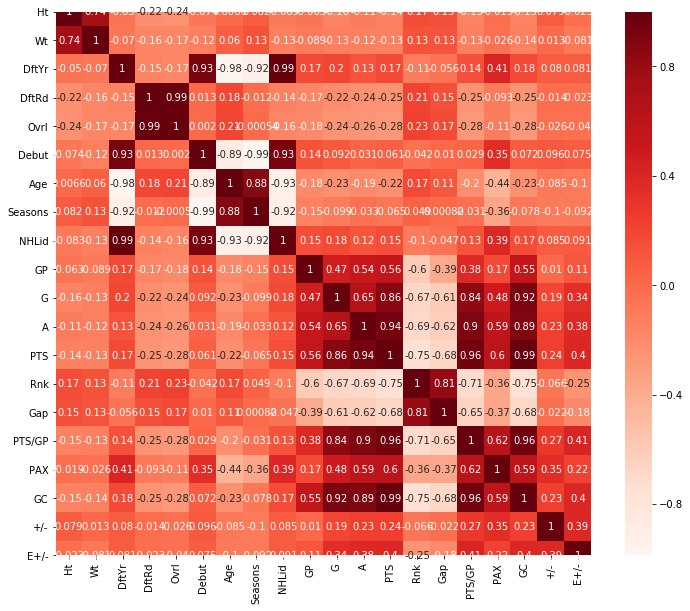

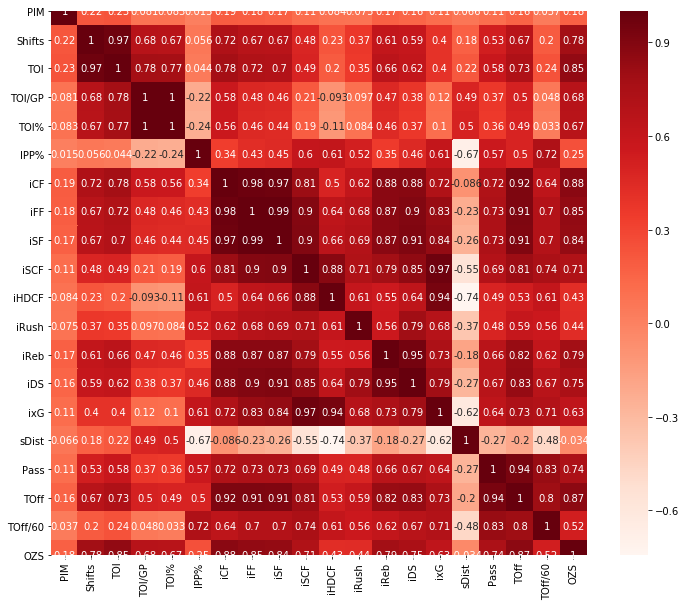

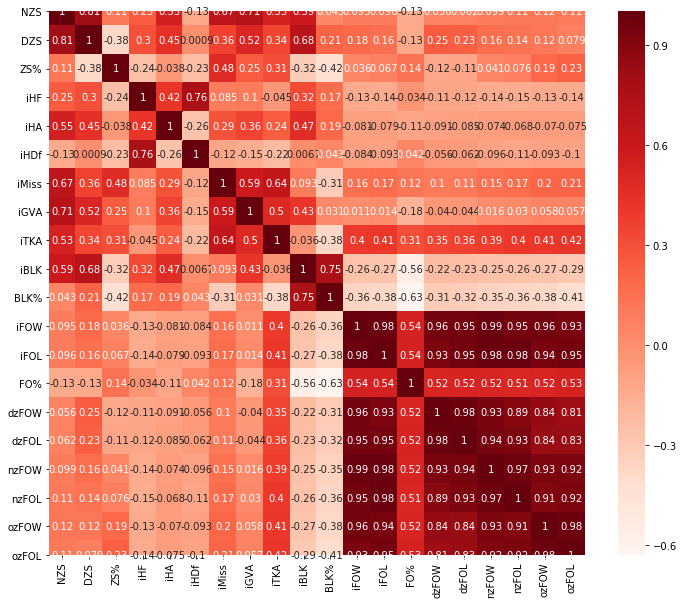

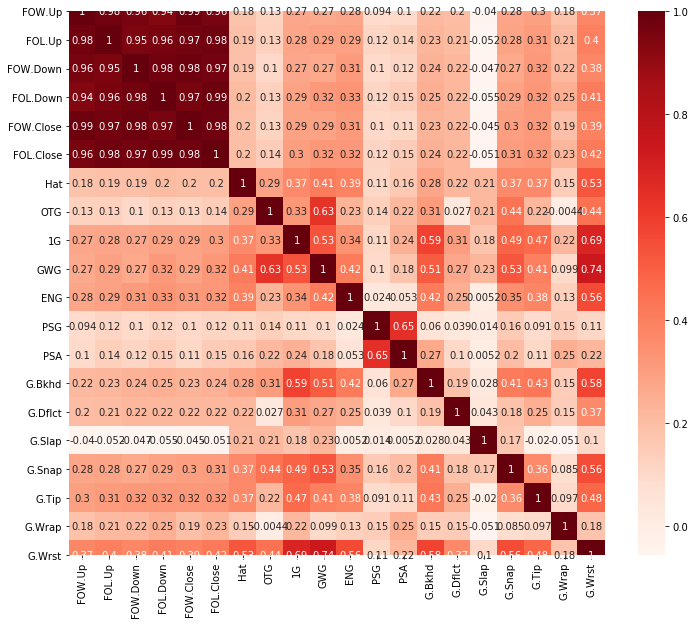

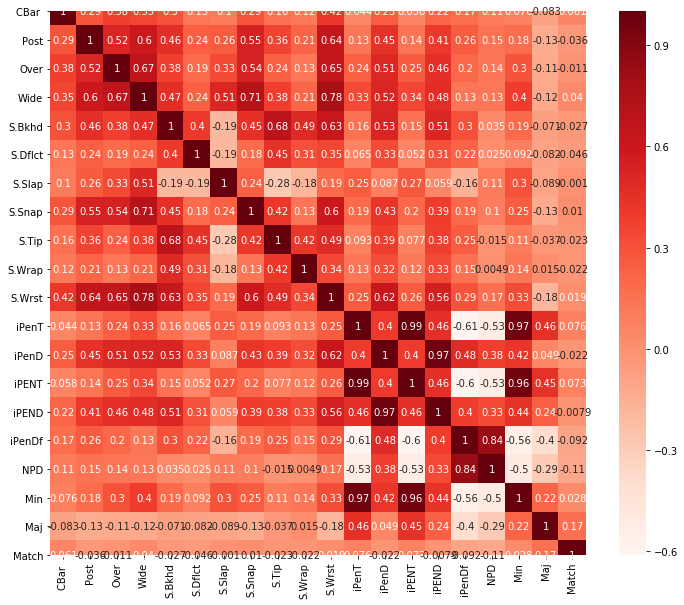

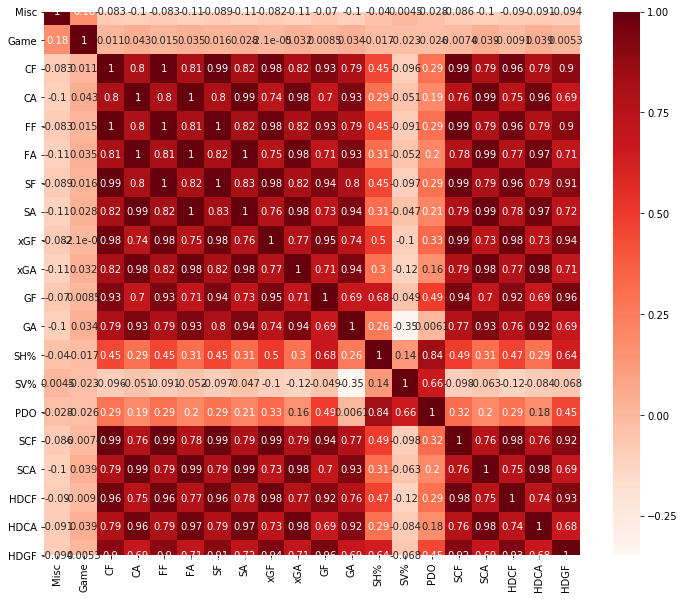

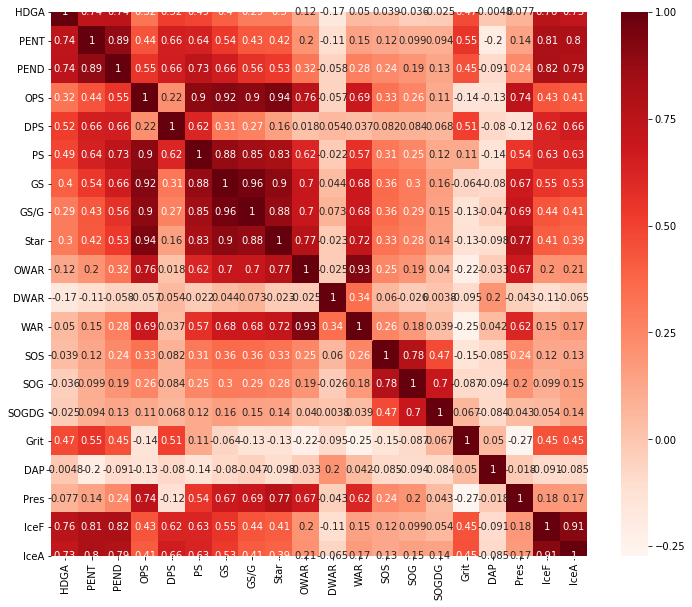

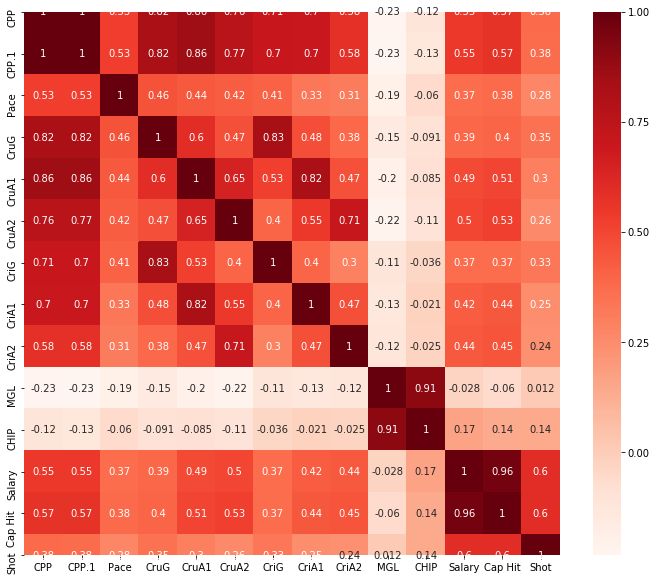

In [5]:
corr = season18.corr()
for i in range(0,int(season18.shape[1]/20)):
    plt.figure(figsize=(12,10))
    sns.heatmap(corr.loc[corr.columns[i*20:i*20+20],corr.columns[i*20:i*20+20]], annot=True, cmap=plt.cm.Reds)
    plt.show()

In [6]:
modelSeason18=season18.copy()
modelSeason18.reset_index(drop=True,inplace=True)

In [7]:
names=modelSeason18['CorsicaID']

In [8]:
modelSeason18.drop(modelSeason18.columns[modelSeason18.dtypes=='object'], axis=1, inplace=True)
modelSeason18.drop(['Born'], axis=1, inplace=True)

In [9]:
modelSeason18.shape

(395, 154)

In [10]:
modelSeason18.fillna('?',inplace=True)

In [11]:
for col in modelSeason18.columns:
    if modelSeason18[col].dtype == object:
        count = 0
        count = [count + 1 for x in modelSeason18[col] if x == '?']
        print(col + ' ' + str(sum(count)))

DftYr 36
DftRd 36
Ovrl 36
SOS 228
SOG 228
SOGDG 228
MGL 131
CHIP 131


In [12]:
modelSeason18.drop(['SOS','SOG','SOGDG','MGL','CHIP','Salary'], axis=1, inplace=True)

In [13]:
for column in modelSeason18.columns:
    modelSeason18.loc[modelSeason18[column] == '?', column] = np.nan
modelSeason18.dropna(axis = 0, inplace = True)
modelSeason18X=modelSeason18.drop(['Cap Hit','NHLid'], axis=1)
modelSeason18Y=modelSeason18[['Cap Hit']]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [14]:
modelSeason18.shape

(359, 148)

In [15]:
modelSeason18X.shape

(359, 146)

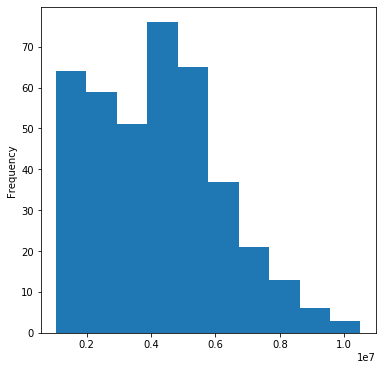

In [16]:
fig = plt.figure(figsize=(6,6)) # define plot area
ax = fig.gca()
season18['Cap Hit'].plot.hist(ax = ax, bins = 10)

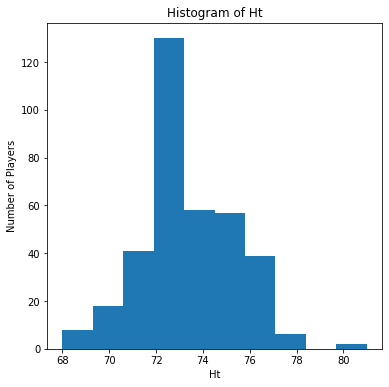

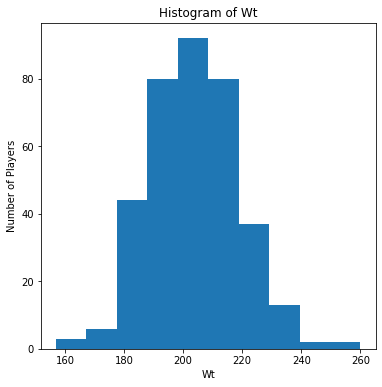

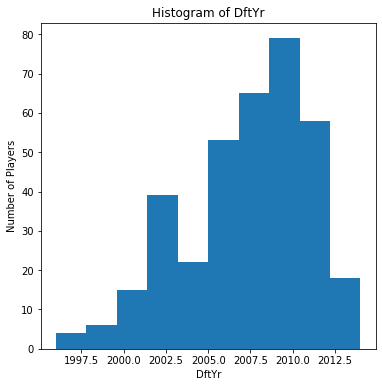

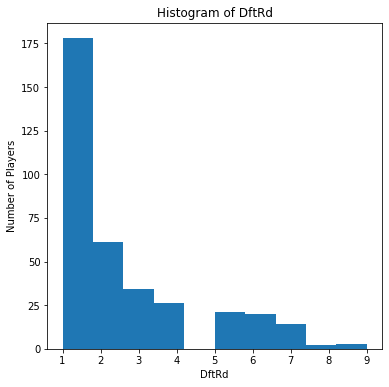

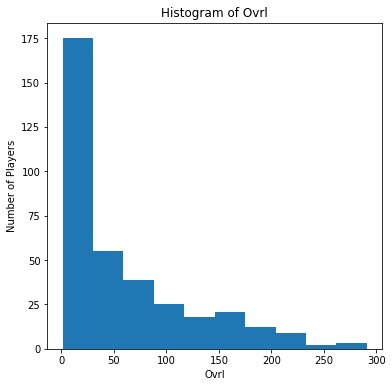

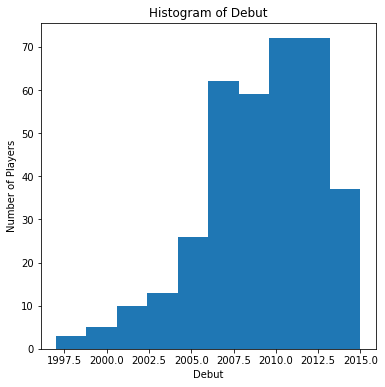

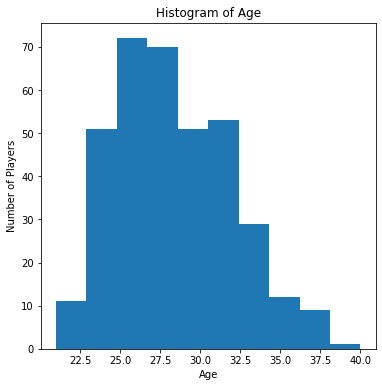

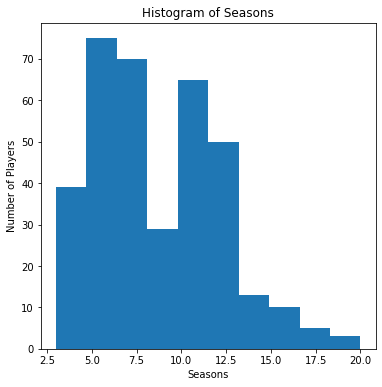

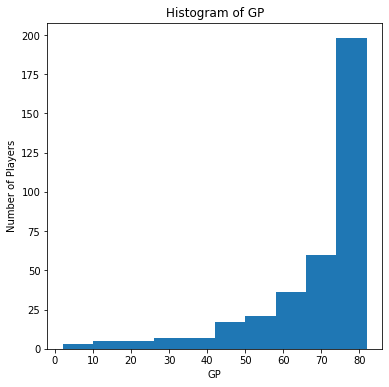

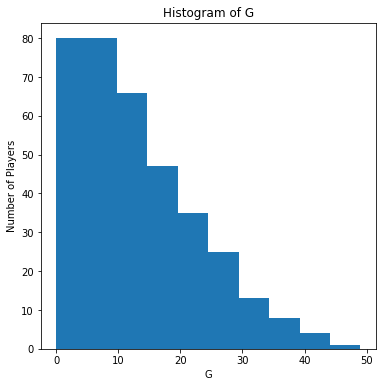

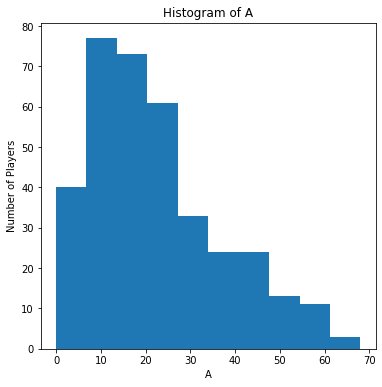

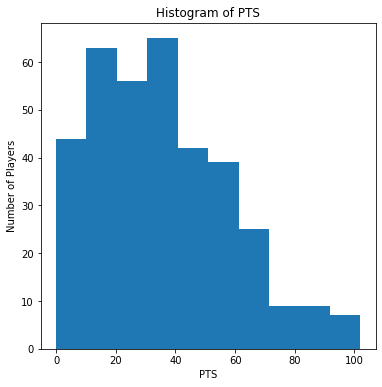

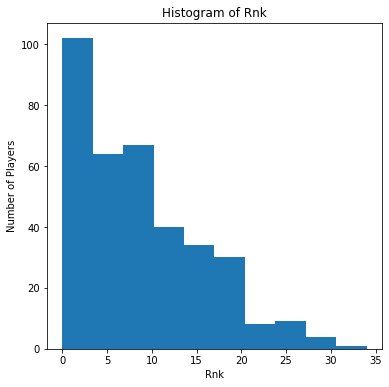

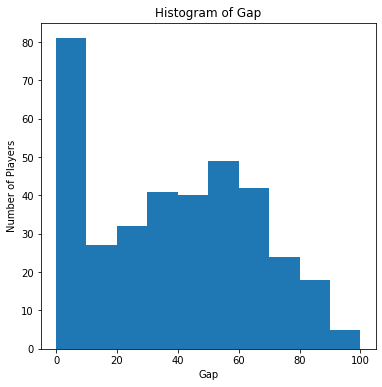

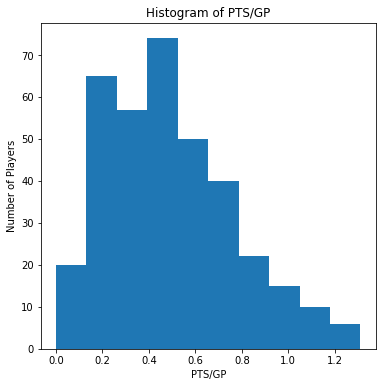

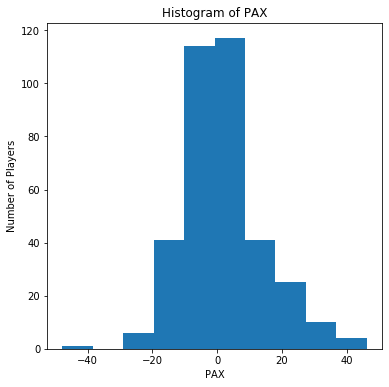

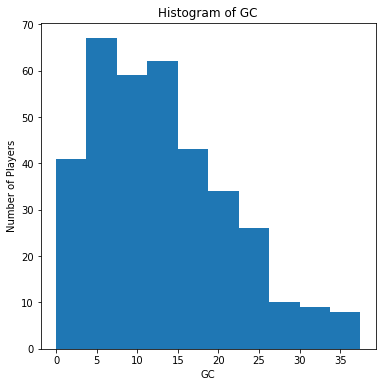

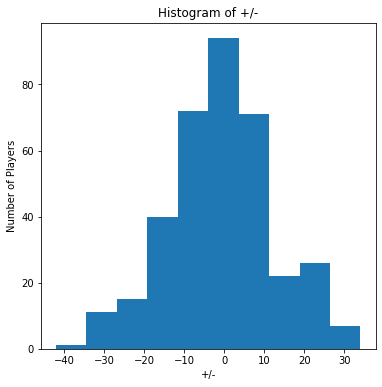

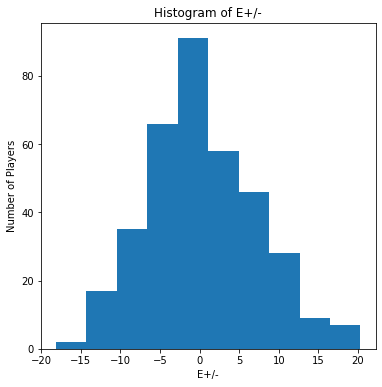

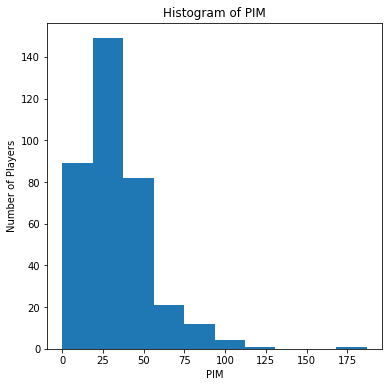

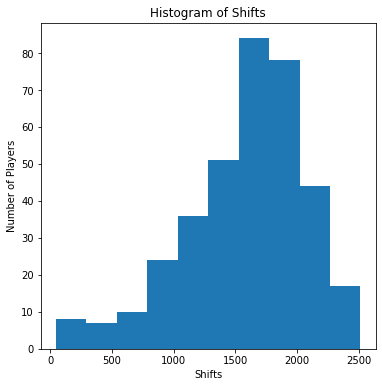

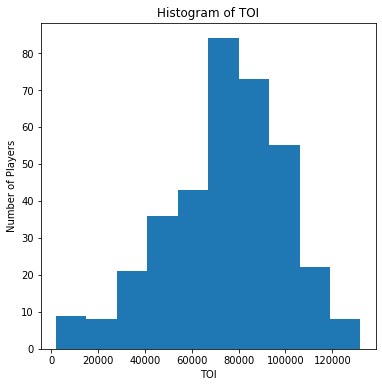

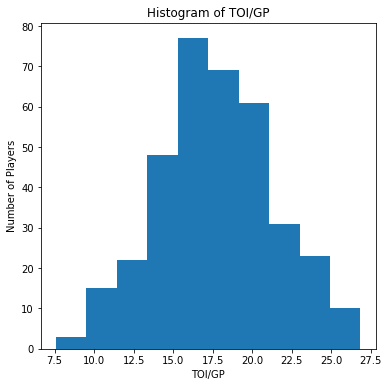

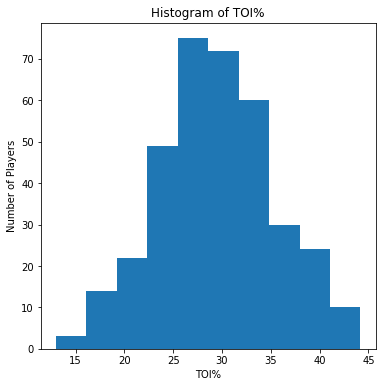

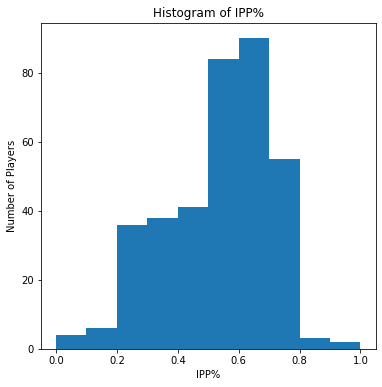

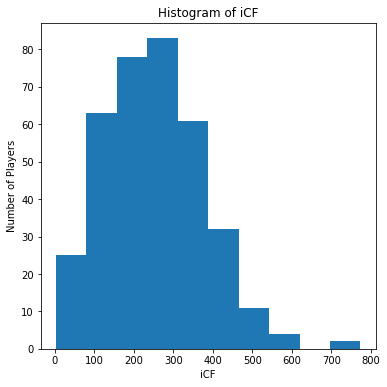

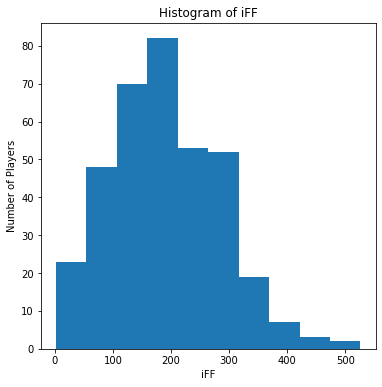

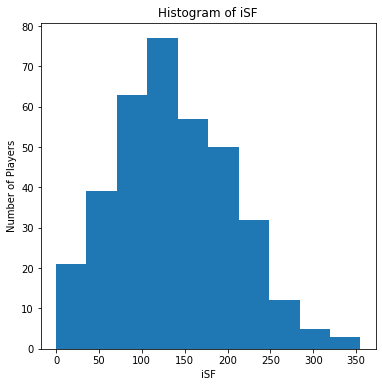

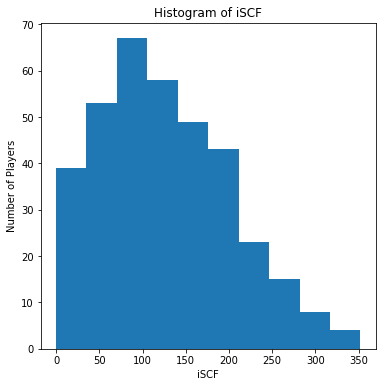

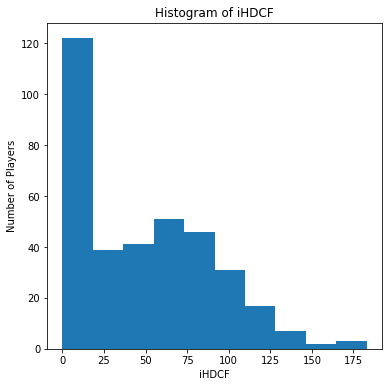

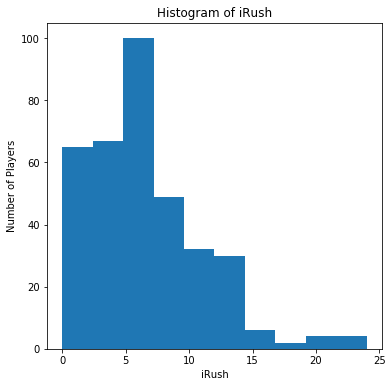

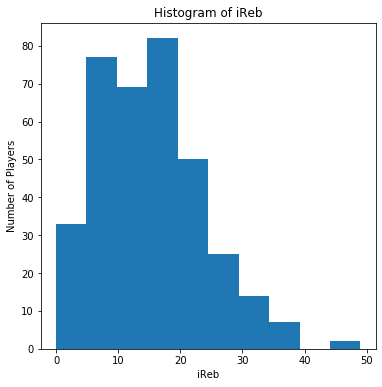

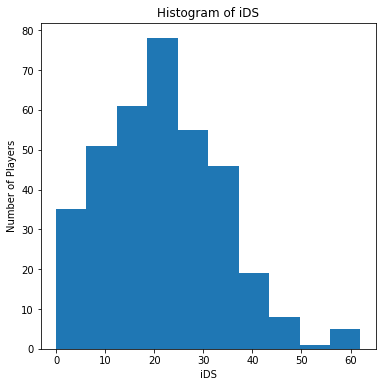

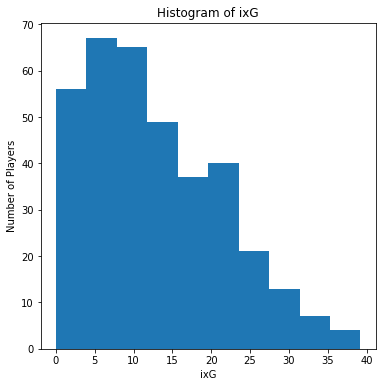

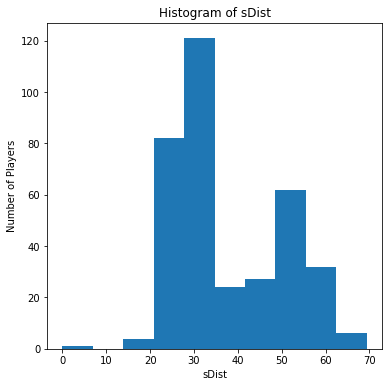

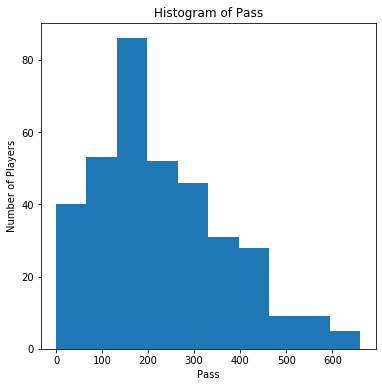

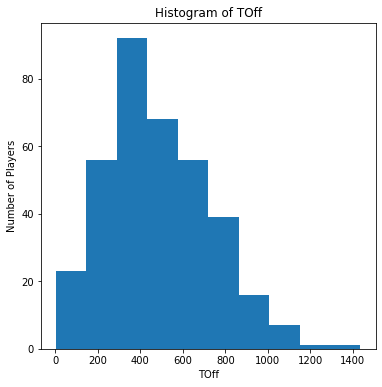

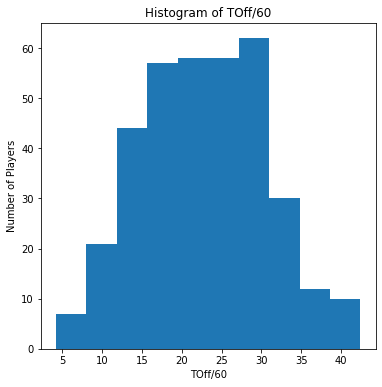

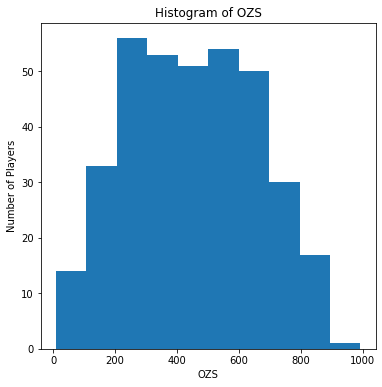

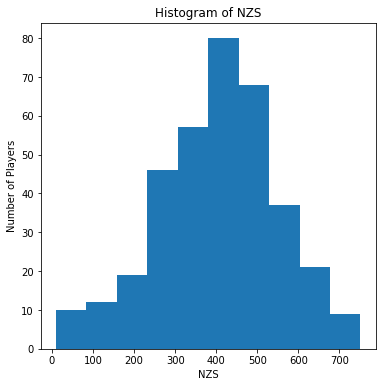

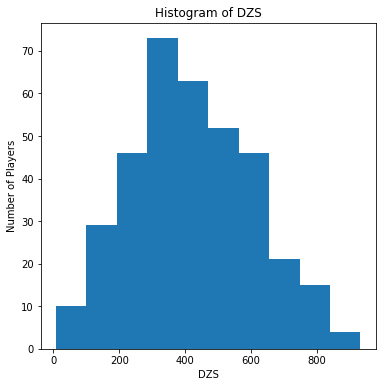

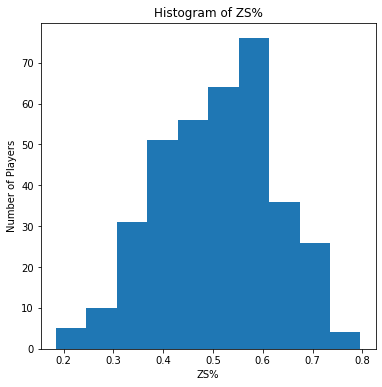

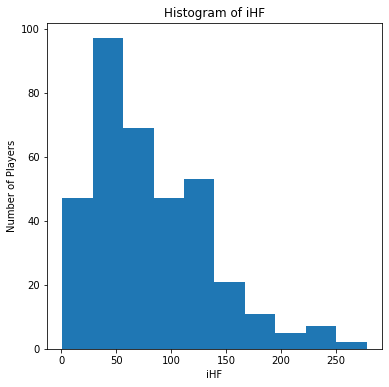

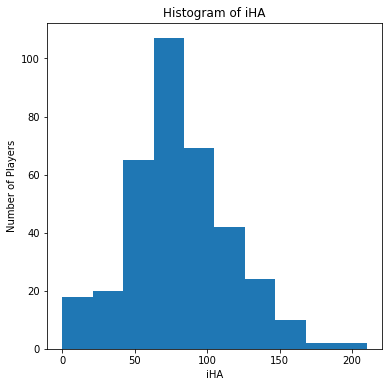

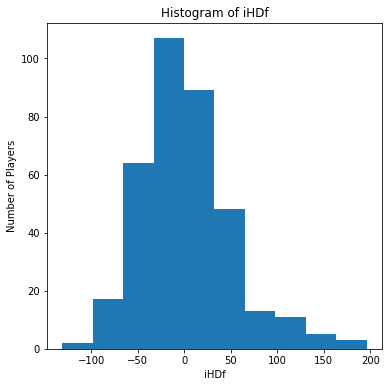

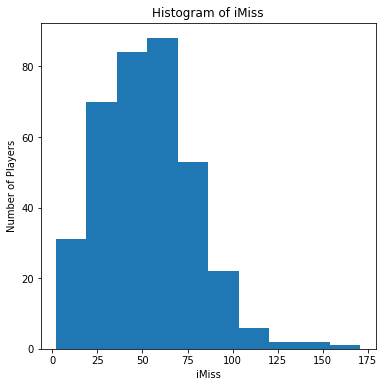

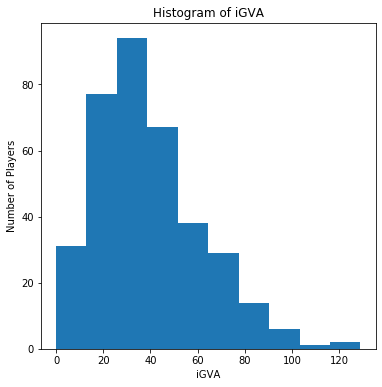

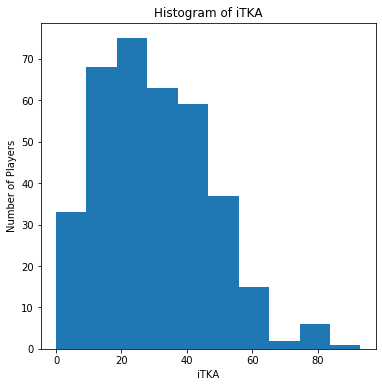

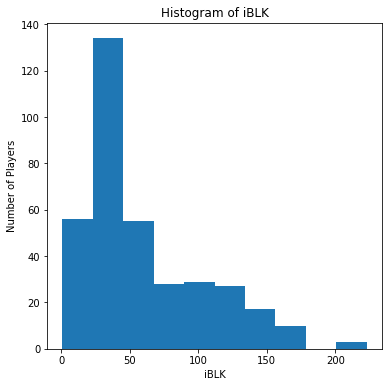

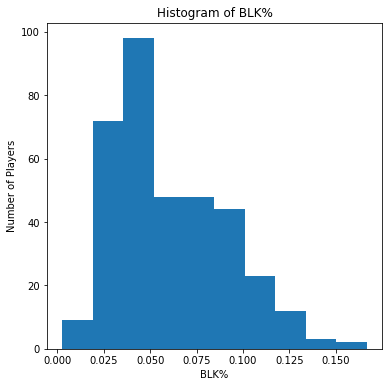

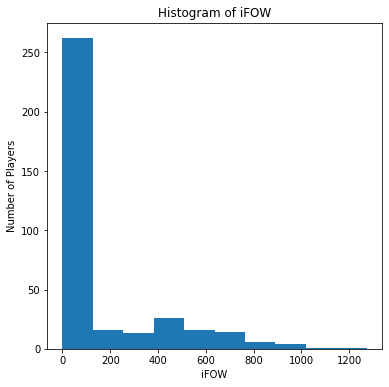

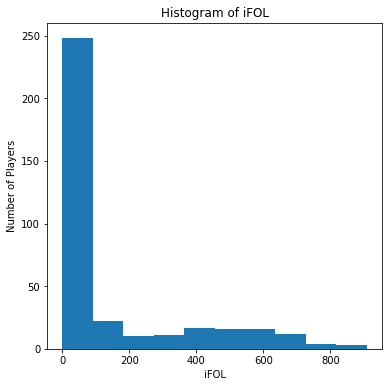

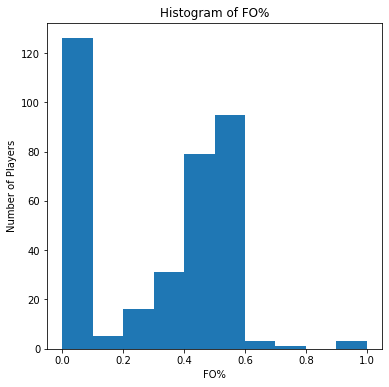

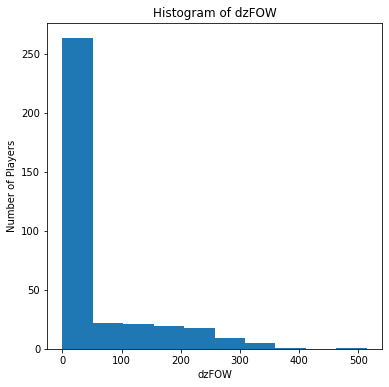

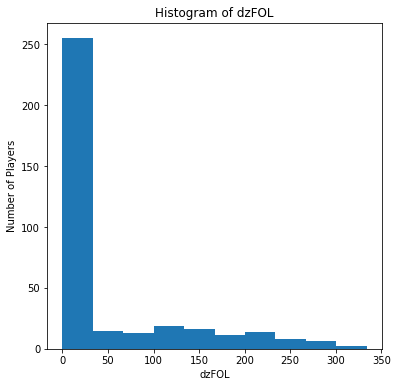

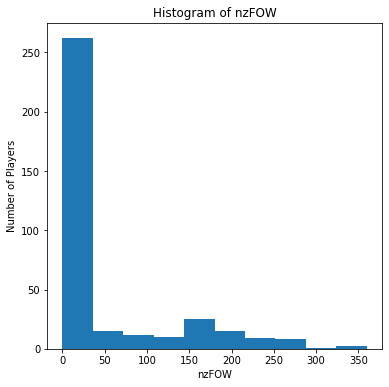

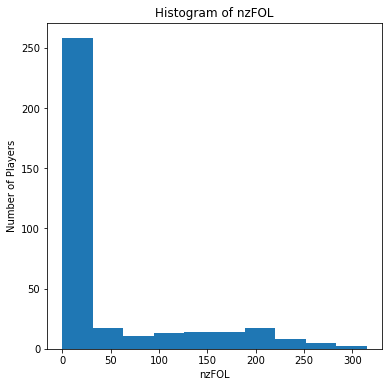

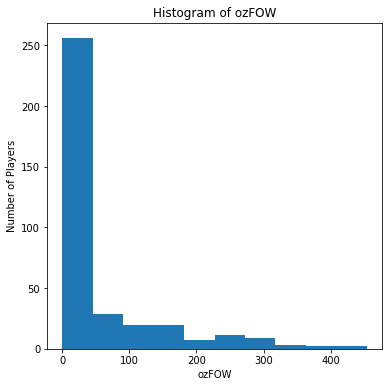

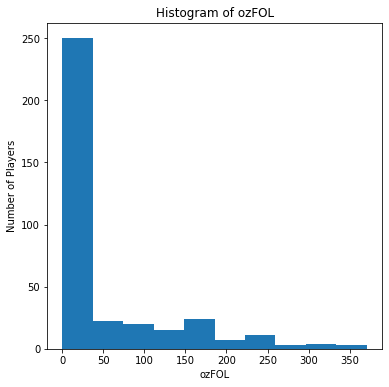

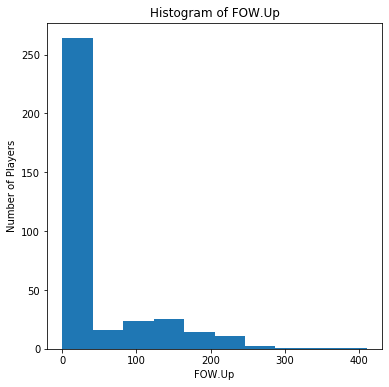

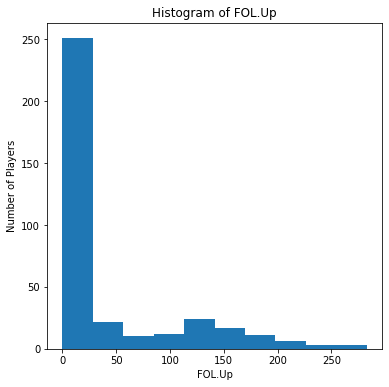

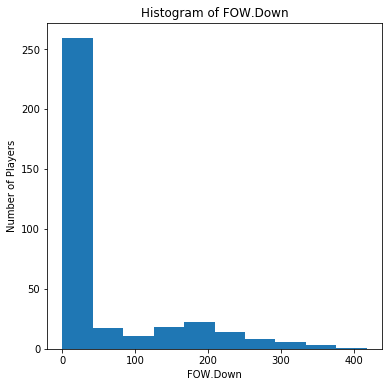

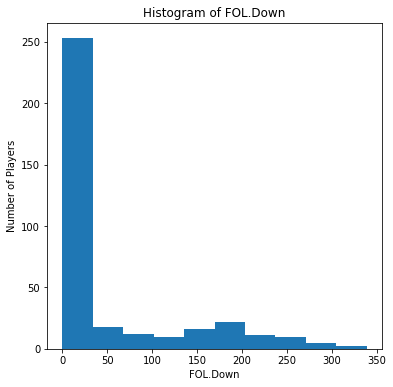

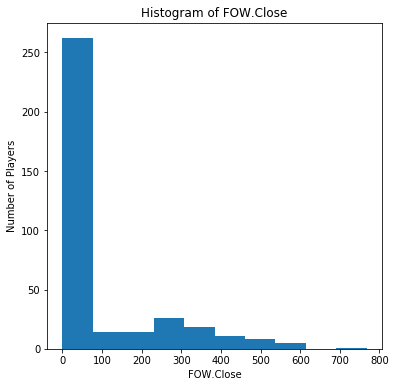

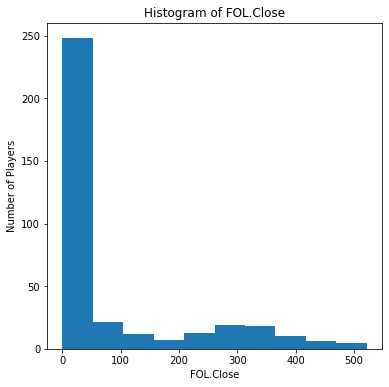

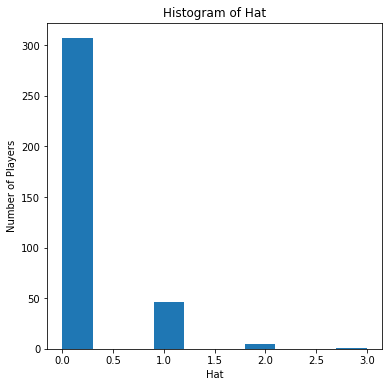

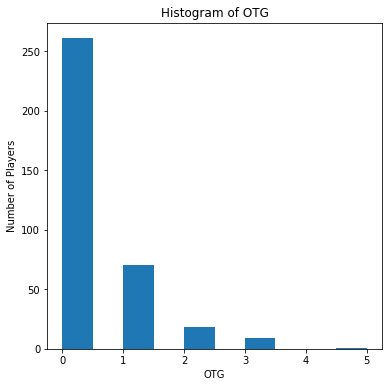

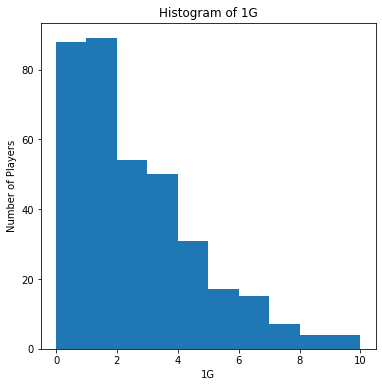

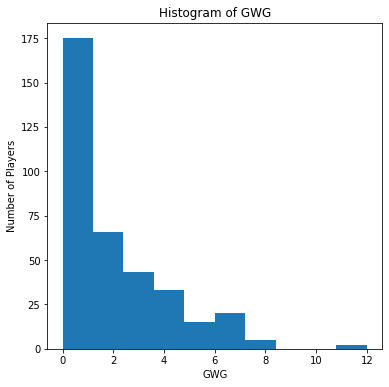

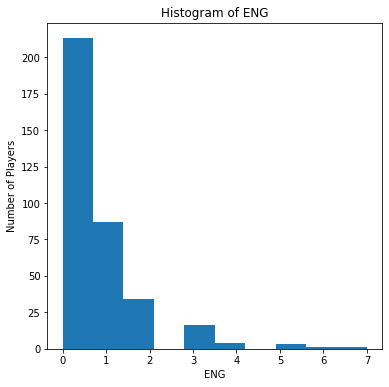

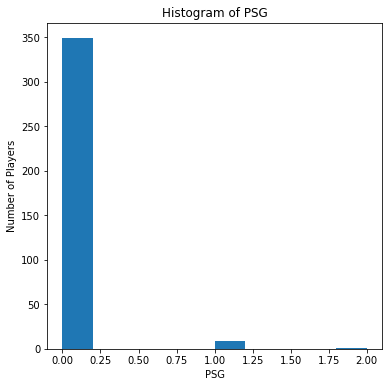

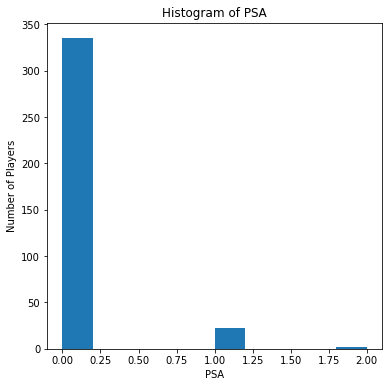

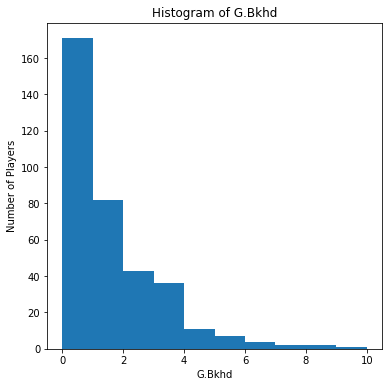

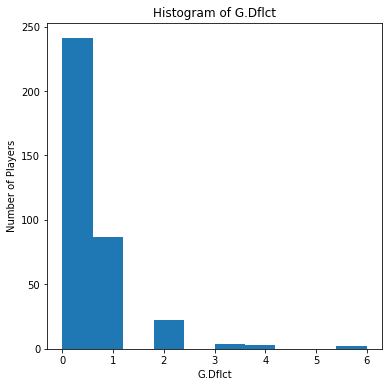

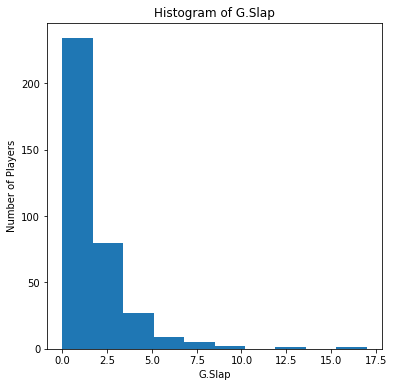

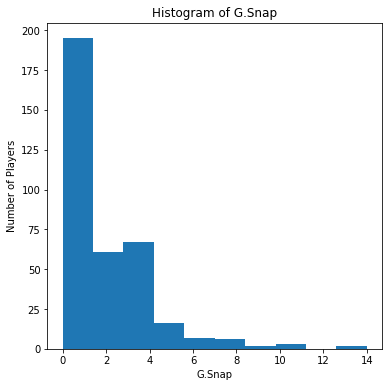

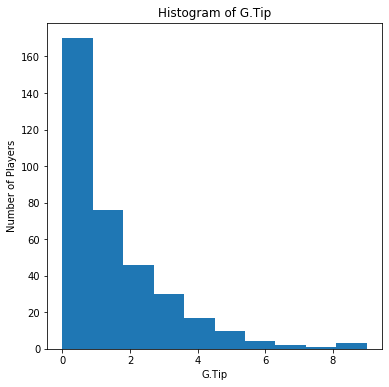

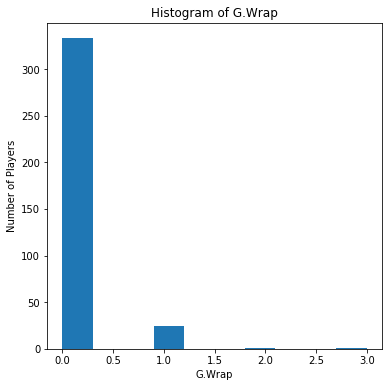

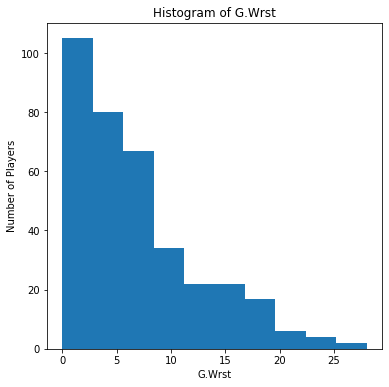

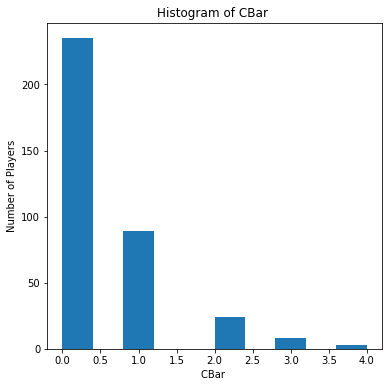

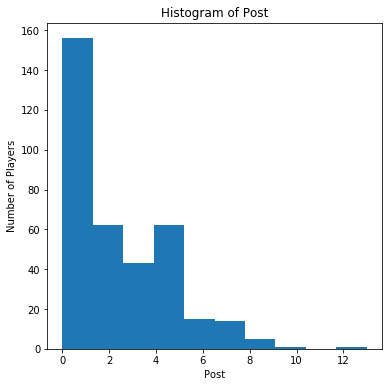

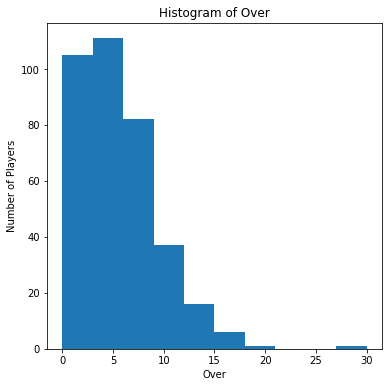

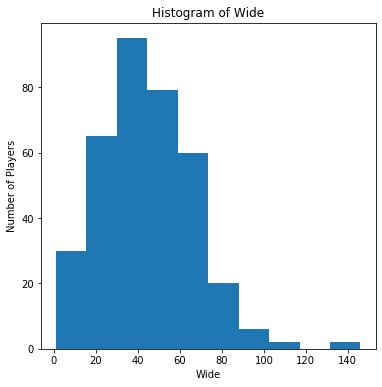

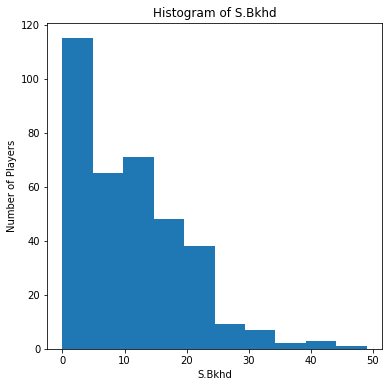

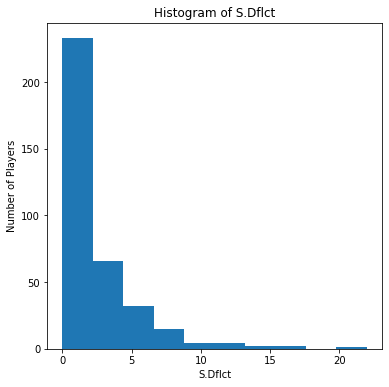

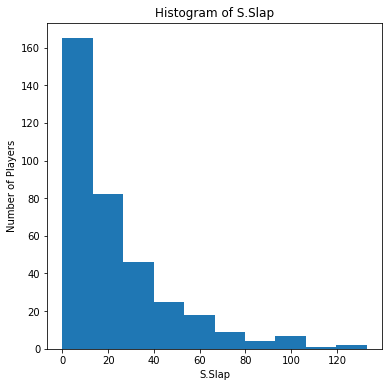

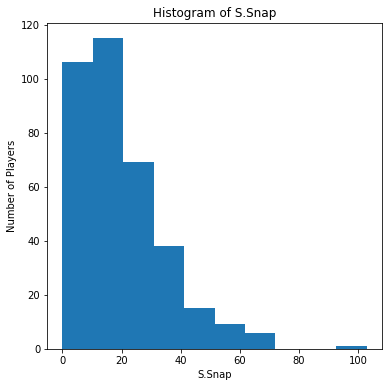

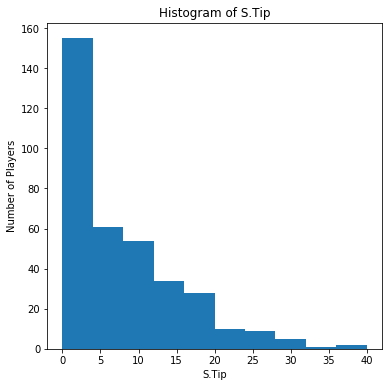

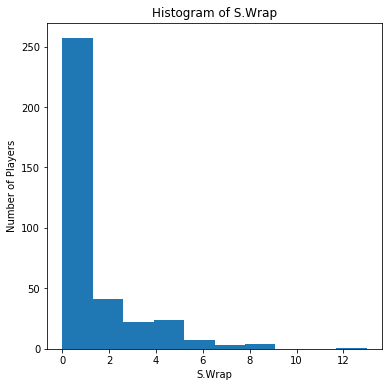

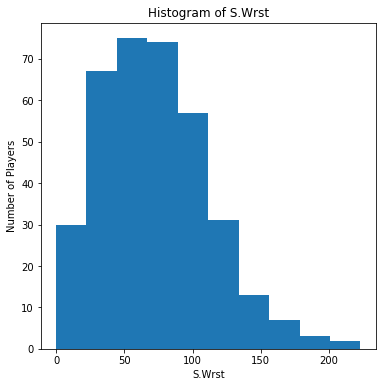

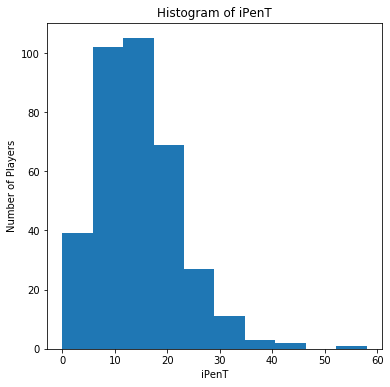

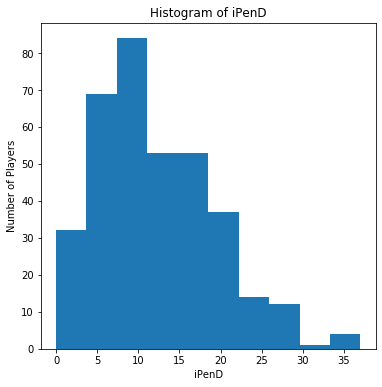

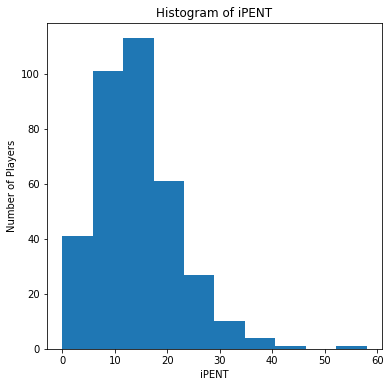

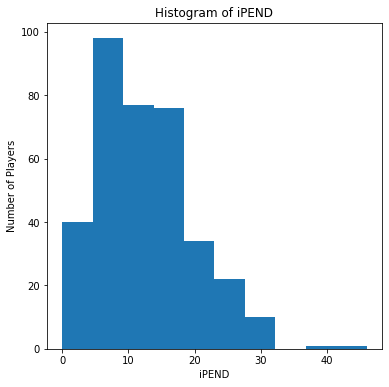

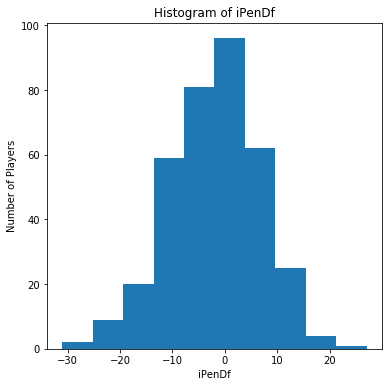

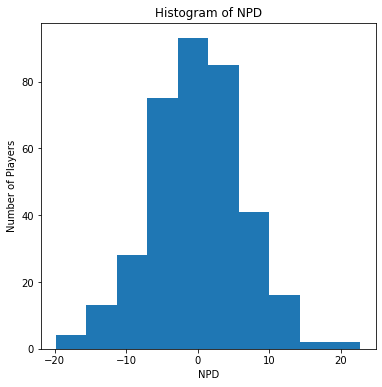

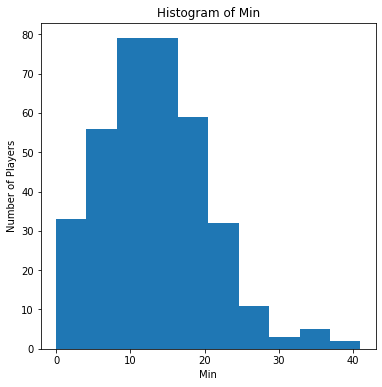

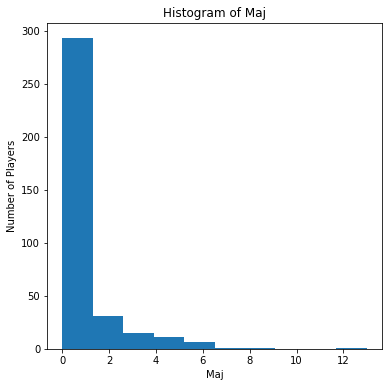

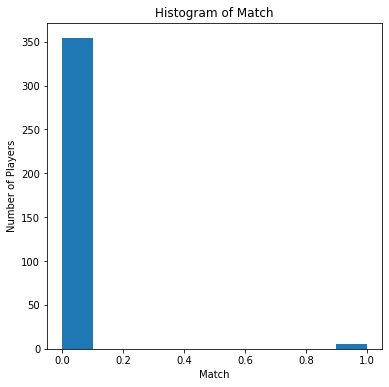

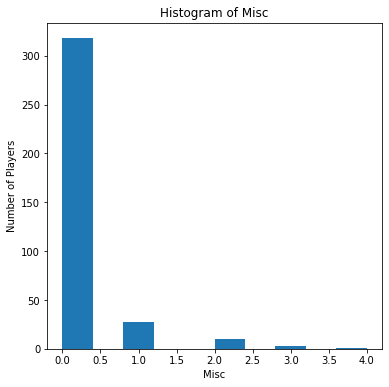

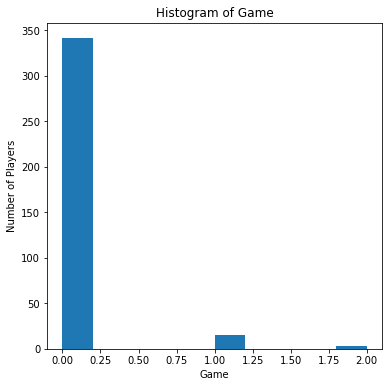

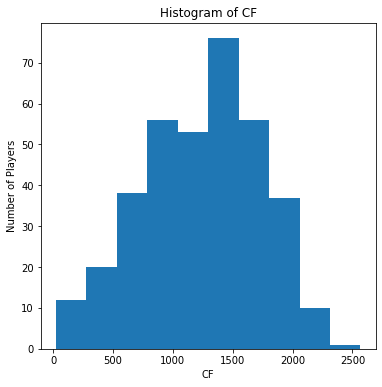

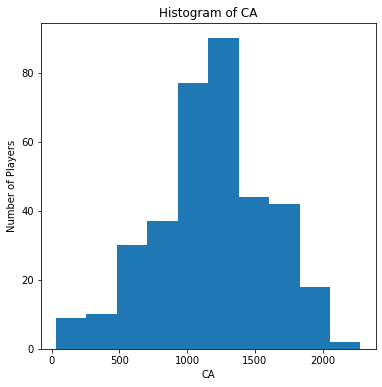

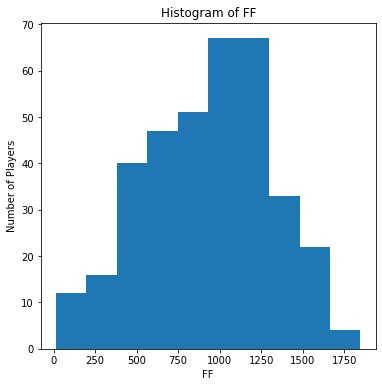

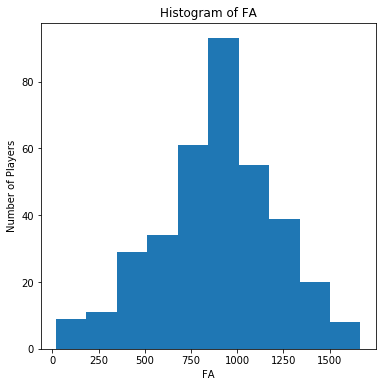

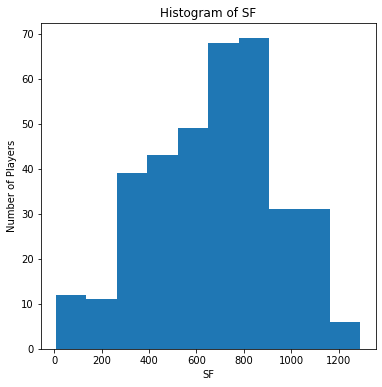

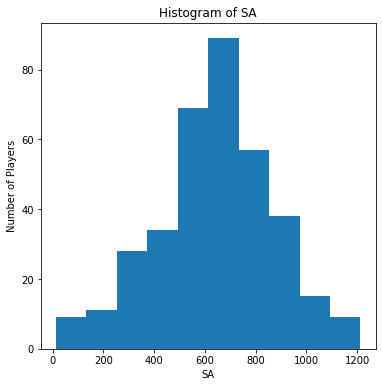

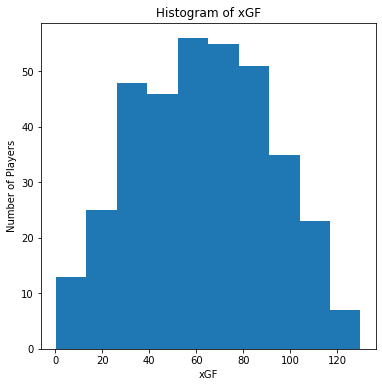

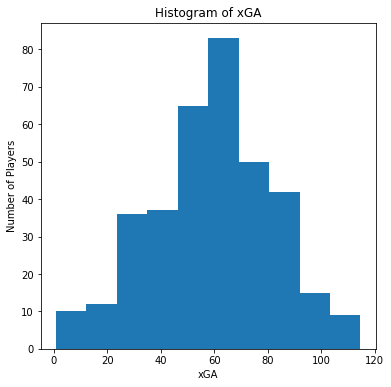

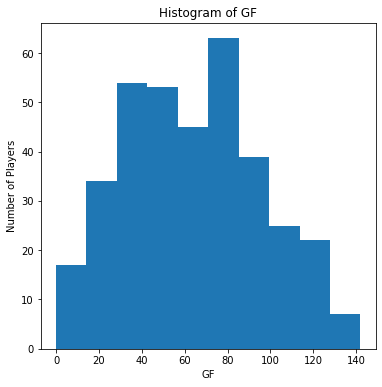

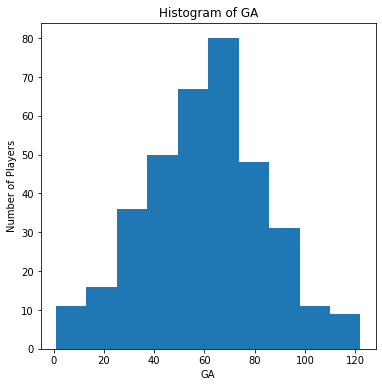

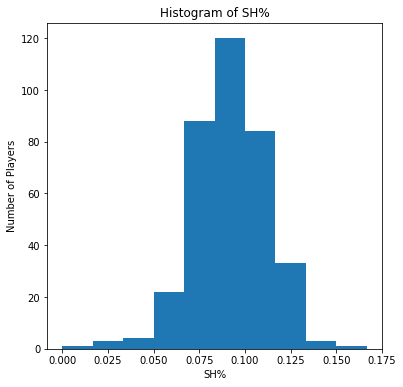

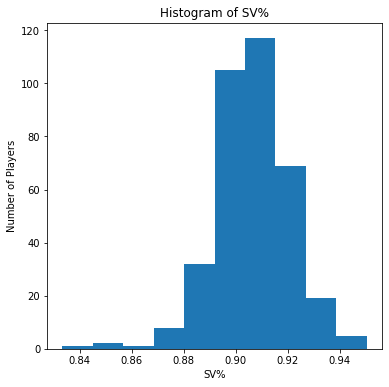

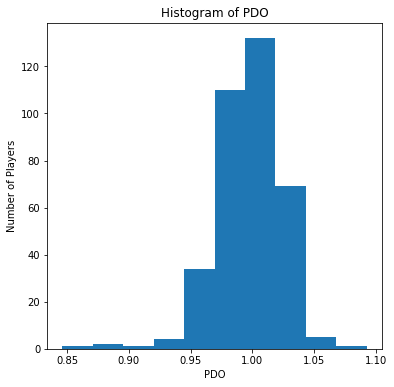

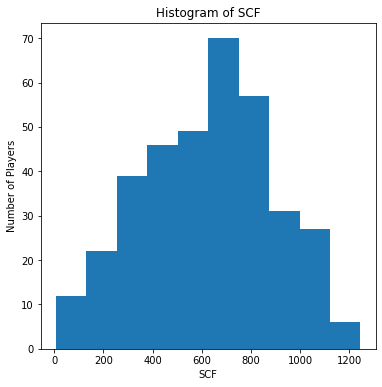

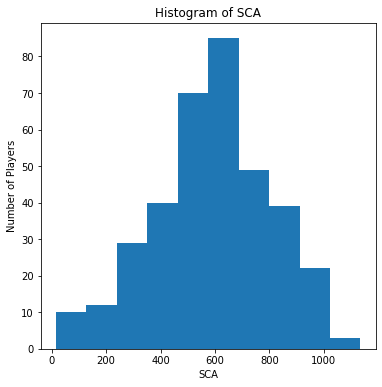

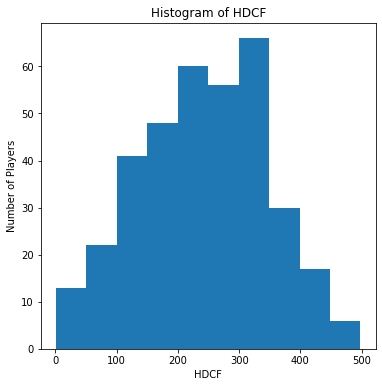

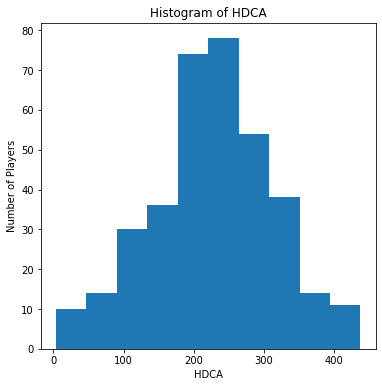

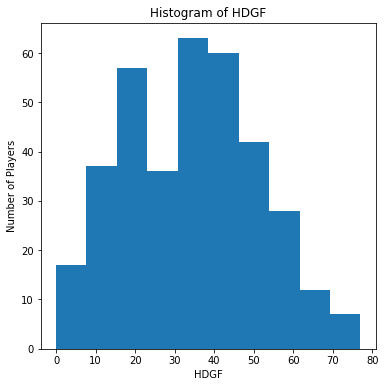

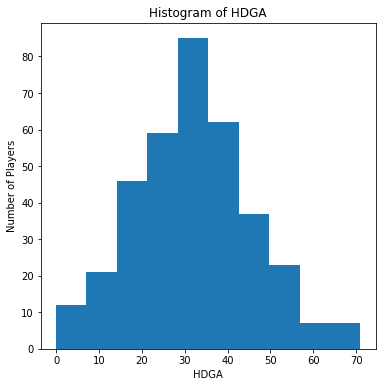

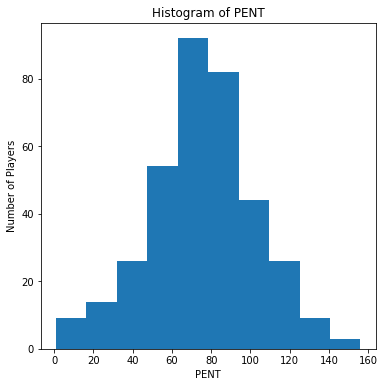

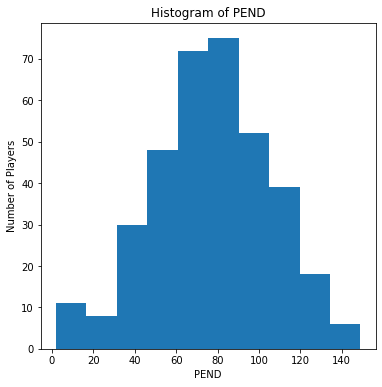

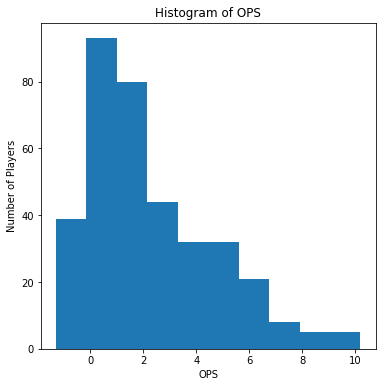

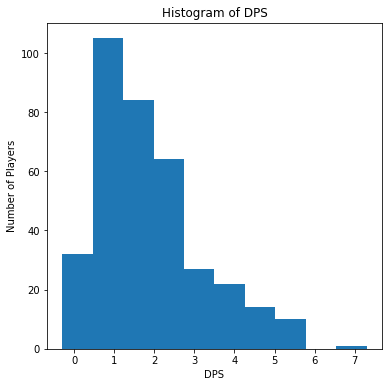

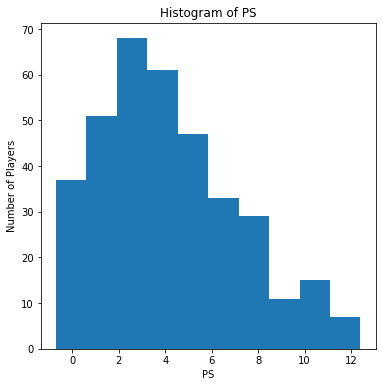

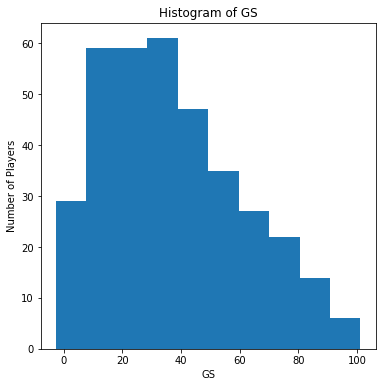

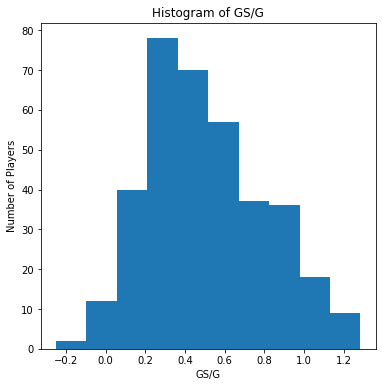

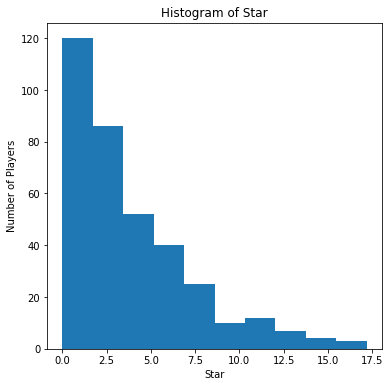

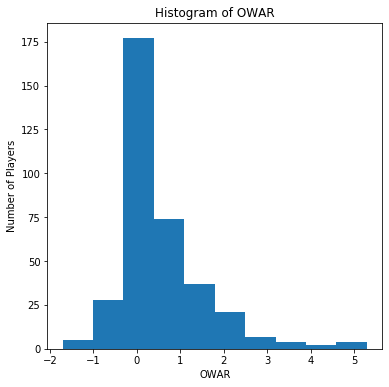

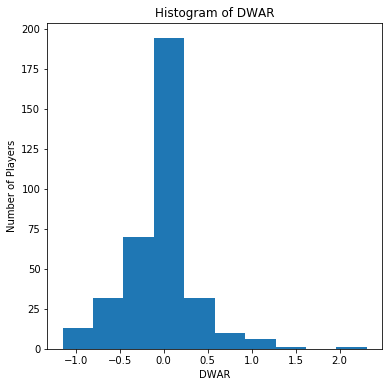

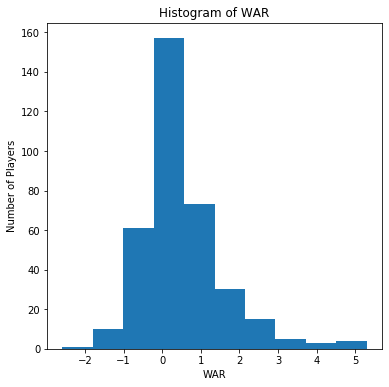

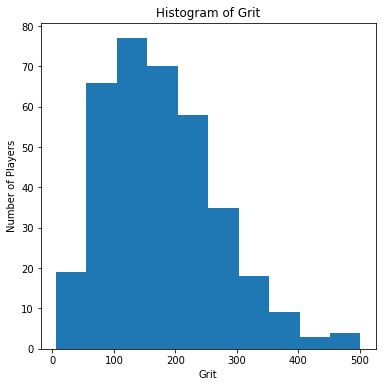

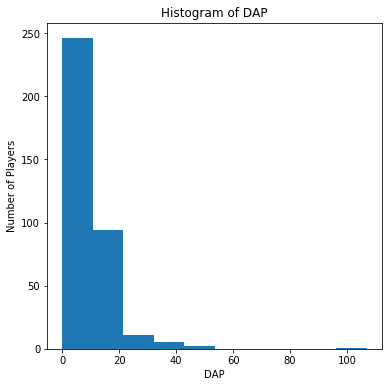

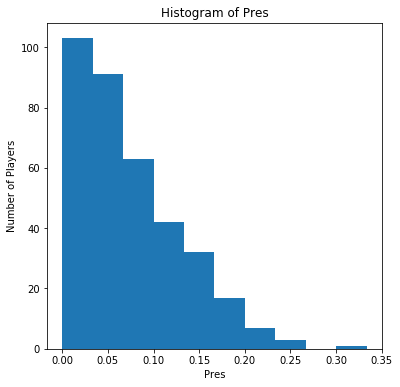

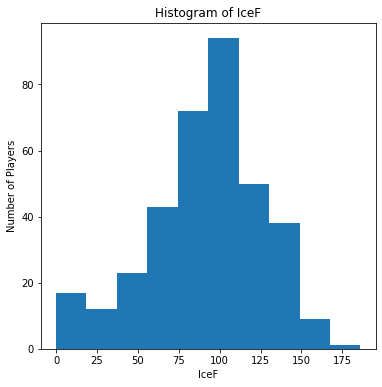

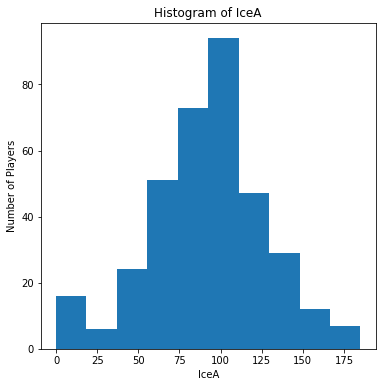

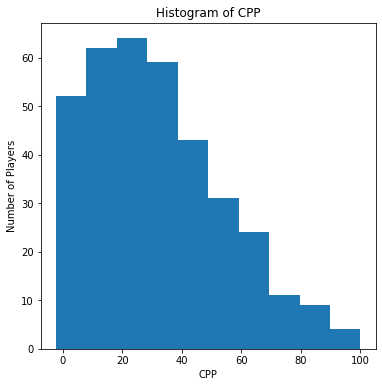

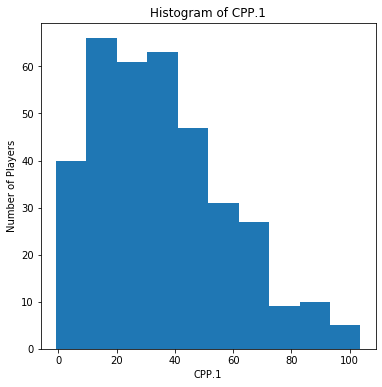

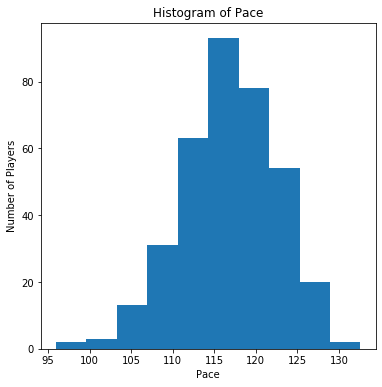

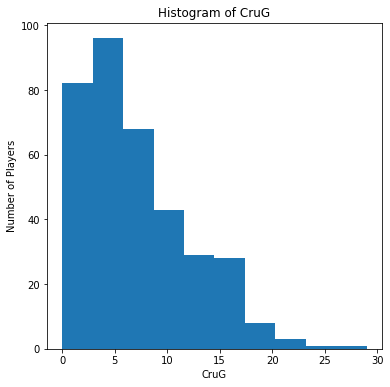

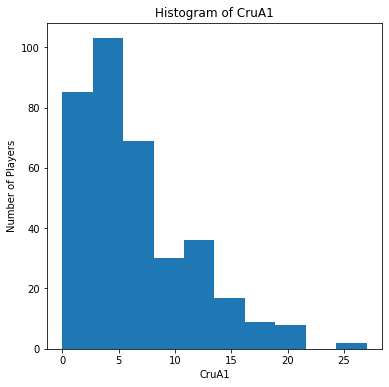

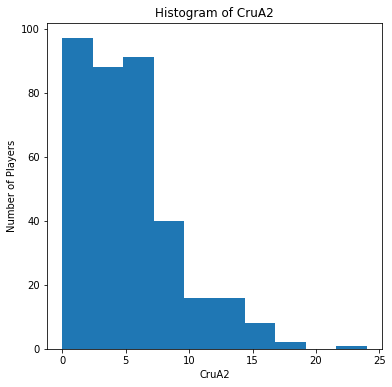

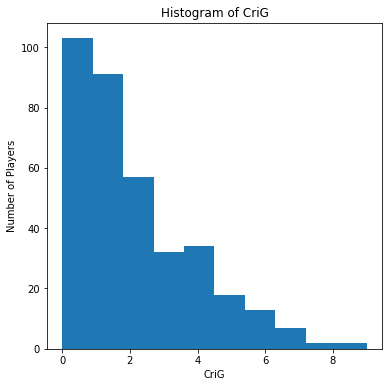

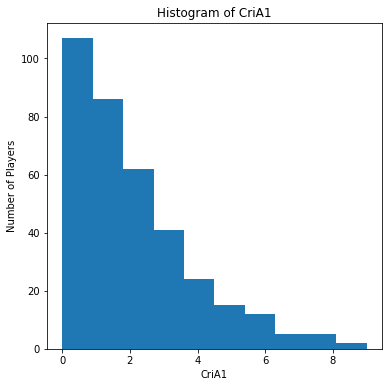

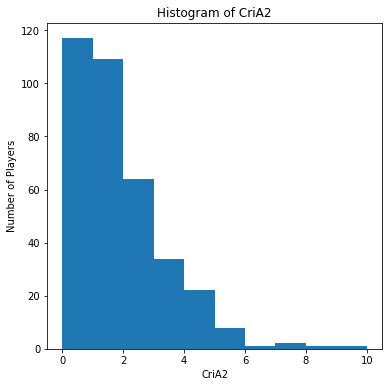

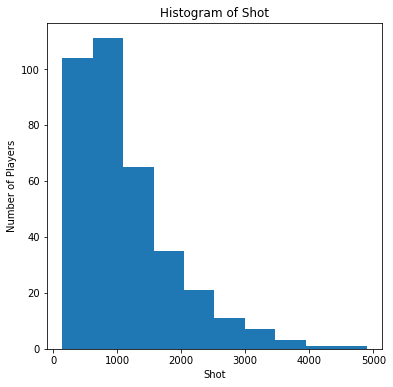

In [17]:
def plot_histogram(season18, cols, bins = 10):
    for col in cols:
        fig = plt.figure(figsize=(6,6)) # define plot area
        ax = fig.gca() # define axis    
        season18[col].plot.hist(ax = ax, bins = bins) # Use the plot.hist method on subset of the data frame
        ax.set_title('Histogram of ' + col) # Give the plot a main title
        ax.set_xlabel(col) # Set text for the x axis
        ax.set_ylabel('Number of Players')# Set text for y axis
        plt.show()
        
num_cols = list(modelSeason18X.columns)
plot_histogram(modelSeason18X, num_cols)

In [18]:
from sklearn import preprocessing

x = modelSeason18X.values
normalized = preprocessing.normalize(x)
modelSeason18X = pd.DataFrame(normalized)

In [19]:
modelSeason18['Cap Hit'].dtypes

dtype('float64')

In [20]:
y=np.log(modelSeason18['Cap Hit'].astype('float64'))

In [21]:
#Backward Elimination
cols = list(modelSeason18X.columns)
pmax = 1
y=np.log(modelSeason18['Cap Hit'].astype('float64'))
count=0
while (len(cols)>0):
    if(count%100==0):
        print(count)
    count=count+1
    p= []
    X_1 = modelSeason18X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(list(y),X_1.astype(float)).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)  
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

0


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


100
[1, 4, 7, 8, 12, 15, 17, 19, 20, 21, 22, 23, 24, 31, 34, 38, 39, 41, 43, 44, 48, 54, 60, 91, 104, 107, 111, 112, 113, 117, 119, 125, 126, 131, 136, 138, 139]


In [22]:
season18.columns[selected_features_BE]

Index(['City', 'Nat', 'DftYr', 'DftRd', 'Age', 'CorsicaID', 'Last Name',
       'Position', 'Team', 'GP', 'G', 'A', 'PTS', 'E+/-', 'TOI', 'iCF', 'iFF',
       'iSCF', 'iRush', 'iReb', 'Pass', 'ZS%', 'iTKA', 'G.Wrst', 'iPenD',
       'iPenDf', 'Match', 'Misc', 'Game', 'FA', 'SA', 'SV%', 'PDO', 'HDGF',
       'DPS', 'GS', 'GS/G'],
      dtype='object')

In [23]:
y

0      15.363073
1      15.068274
2      14.914123
4      15.201805
5      15.520259
         ...    
390    15.193437
391    15.201805
392    15.520259
393    15.165437
394    15.687313
Name: Cap Hit, Length: 359, dtype: float64

In [24]:
len(selected_features_BE)

37

In [25]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [26]:
X_train, X_test, y_train, y_test = train_test_split(modelSeason18X,y, test_size = 0.2, random_state = 0)

In [27]:
X2_train=X_train[[5, 8, 14, 15, 20, 21, 22, 27, 38, 39, 40, 42, 43, 51, 57, 85, 89, 90, 91, 94, 96, 104, 105, 107, 110, 118, 133, 136, 143]]
y2_train=y_train.copy()
X2_test=X_test[[5, 8, 14, 15, 20, 21, 22, 27, 38, 39, 40, 42, 43, 51, 57, 85, 89, 90, 91, 94, 96, 104, 105, 107, 110, 118, 133, 136, 143]]
y2_test=y_test.copy()

In [28]:
reg = LassoCV()
reg.fit(X_train, y_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_test,y_test))
coef = pd.Series(reg.coef_, index = X_test.columns)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006261725598459833, tolerance: 0.005549042833874691
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0067680069667126475, tolerance: 0.005549042833874691
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase th

Best alpha using built-in LassoCV: 0.000106
Best score using built-in LassoCV: 0.366232


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008421010202440016, tolerance: 0.005320181260004035
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00856994654074228, tolerance: 0.005320181260004035
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00836464523950653, tolerance: 0.005320181260004035
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not conver

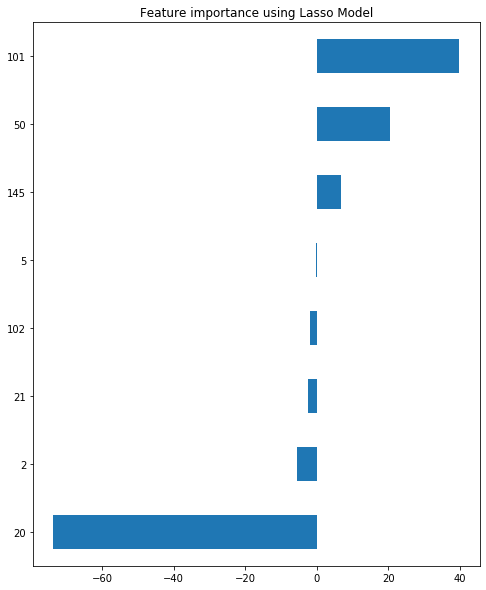

In [29]:
imp_coef = coef.sort_values()
imp_coef=imp_coef[imp_coef!=0]
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
plt.show()

(array([ 1.,  2.,  1.,  5.,  5., 14., 18., 10., 10.,  6.]),
 array([-77905.39653542, -66444.36756757, -54983.33859971, -43522.30963186,
        -32061.28066401, -20600.25169616,  -9139.22272831,   2321.80623954,
         13782.83520739,  25243.86417524,  36704.89314309]),
 <a list of 10 Patch objects>)

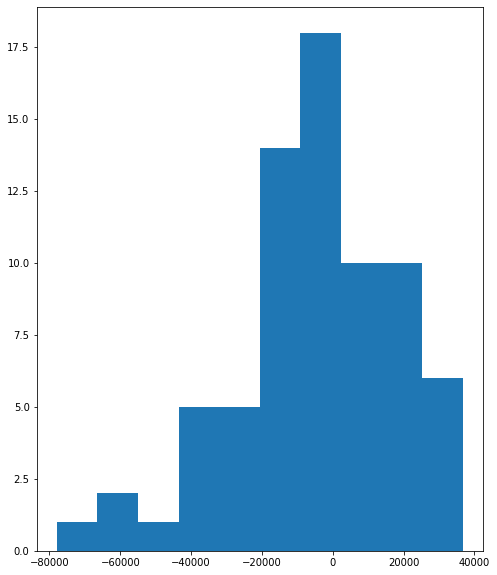

In [30]:
plt.hist((np.exp(reg.predict(X_test))-np.exp(y_test))/len(y_test))

(array([22., 16., 14., 10.,  5.,  1.,  1.,  2.,  0.,  1.]),
 array([5.80737959e+01, 7.84280607e+03, 1.56275383e+04, 2.34122706e+04,
        3.11970029e+04, 3.89817352e+04, 4.67664674e+04, 5.45511997e+04,
        6.23359320e+04, 7.01206643e+04, 7.79053965e+04]),
 <a list of 10 Patch objects>)

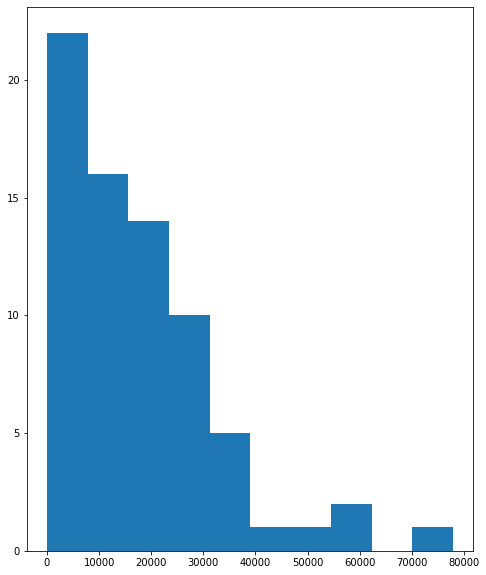

In [31]:
plt.hist((abs(np.exp(reg.predict(X_test))-np.exp(y_test)))/len(y_test))

In [32]:
diff=np.exp(reg.predict(X_test))-np.exp(y_test)
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-3371972.657447482
-146020.59846032457
1933242.4590058867
19


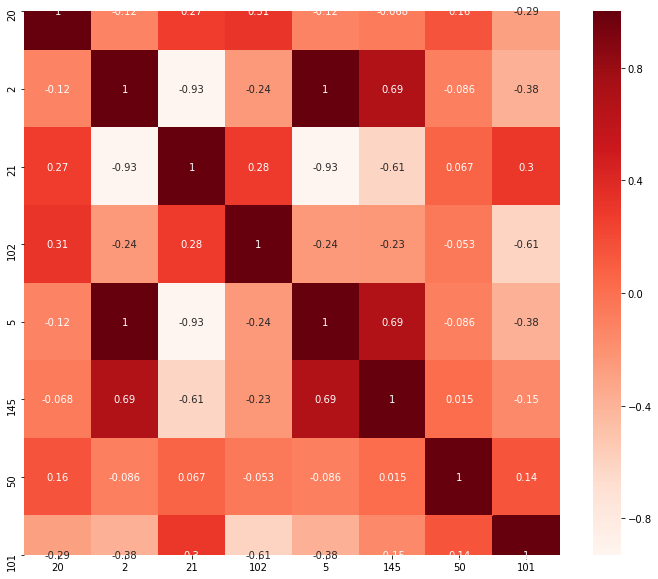

In [33]:
corr = modelSeason18X[imp_coef.index].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr.loc[corr.columns,corr.columns], annot=True, cmap=plt.cm.Reds)
plt.show()

In [34]:
X_train, X_test, y_train, y_test = train_test_split(modelSeason18X[imp_coef.index],y, test_size = 0.2, random_state = 0)

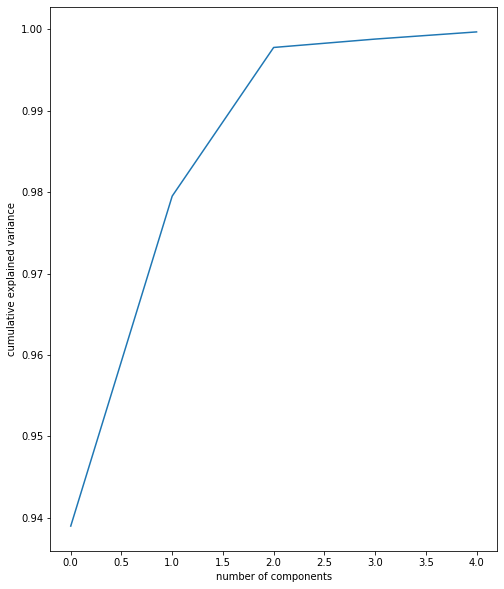

In [35]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_)[0:5])
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [36]:
pca=PCA(2)
pca.fit(X_train)
pcatrain_x = pca.transform(X_train)
pcatest_x = pca.transform(X_test)
reg = LassoCV()
reg.fit(pcatrain_x, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [37]:
diff=np.exp(reg.predict(pcatest_x))-np.exp(y_test)
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))
print(reg.score(pcatest_x, y_test))

-5051827.215946036
-284001.2250891342
2456187.609023433
17
0.09440633675404199


In [38]:
import xgboost as xgb
dtrain=xgb.DMatrix(X_train,y_train)
dtest=xgb.DMatrix(X_test,y_test)
params={
    'objective':"reg:squarederror",
    'eval_metric':["rmse","mae"]
}
evallist=[(dtest,'eval'),(dtrain,'train')]

In [39]:
num_round = 1000
bst=xgb.train(params,dtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-rmse:10.26212	eval-mae:10.24631	train-rmse:10.28330	train-mae:10.26957
Multiple eval metrics have been passed: 'train-mae' will be used for early stopping.

Will train until train-mae hasn't improved in 10 rounds.
[1]	eval-rmse:7.19870	eval-mae:7.17614	train-rmse:7.21897	train-mae:7.19940
[2]	eval-rmse:5.05599	eval-mae:5.02382	train-rmse:5.07496	train-mae:5.04708
[3]	eval-rmse:3.56078	eval-mae:3.51496	train-rmse:3.57788	train-mae:3.53821
[4]	eval-rmse:2.52460	eval-mae:2.46585	train-rmse:2.53376	train-mae:2.48406
[5]	eval-rmse:1.80596	eval-mae:1.74058	train-rmse:1.80462	train-mae:1.74777
[6]	eval-rmse:1.29037	eval-mae:1.20959	train-rmse:1.29466	train-mae:1.23421
[7]	eval-rmse:0.95313	eval-mae:0.86482	train-rmse:0.93977	train-mae:0.87729
[8]	eval-rmse:0.72243	eval-mae:0.63406	train-rmse:0.69138	train-mae:0.62470
[9]	eval-rmse:0.59127	eval-mae:0.50416	train-rmse:0.51760	train-mae:0.45528
[10]	eval-rmse:0.50944	eval-mae:0.43021	train-rmse:0.39656	train-mae:0.33734
[11]	eval-rmse:0

[105]	eval-rmse:0.43416	eval-mae:0.34603	train-rmse:0.00102	train-mae:0.00071
[106]	eval-rmse:0.43416	eval-mae:0.34603	train-rmse:0.00102	train-mae:0.00071
[107]	eval-rmse:0.43416	eval-mae:0.34603	train-rmse:0.00102	train-mae:0.00071
[108]	eval-rmse:0.43416	eval-mae:0.34603	train-rmse:0.00102	train-mae:0.00071
[109]	eval-rmse:0.43416	eval-mae:0.34603	train-rmse:0.00102	train-mae:0.00071
[110]	eval-rmse:0.43416	eval-mae:0.34603	train-rmse:0.00102	train-mae:0.00071
[111]	eval-rmse:0.43416	eval-mae:0.34603	train-rmse:0.00102	train-mae:0.00071
[112]	eval-rmse:0.43416	eval-mae:0.34603	train-rmse:0.00102	train-mae:0.00071
[113]	eval-rmse:0.43416	eval-mae:0.34603	train-rmse:0.00102	train-mae:0.00071
[114]	eval-rmse:0.43416	eval-mae:0.34603	train-rmse:0.00102	train-mae:0.00071
[115]	eval-rmse:0.43416	eval-mae:0.34603	train-rmse:0.00102	train-mae:0.00071
Stopping. Best iteration:
[105]	eval-rmse:0.43416	eval-mae:0.34603	train-rmse:0.00102	train-mae:0.00071



In [40]:
xgbPred=bst.predict(dtest,ntree_limit=bst.best_ntree_limit)

In [41]:
diff=np.exp(xgbPred)-np.exp(y_test)
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))


-3238244.5
47067.87500000093
2597809.9999999953
16


In [42]:
from sklearn.metrics import mean_squared_error
mean_squared_error(xgbPred,y_test)

0.18849226265393668

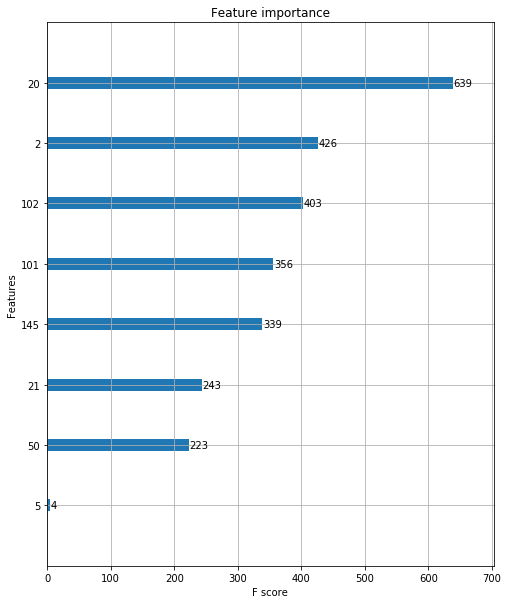

In [43]:
xgb.plot_importance(bst)

(array([ 1.,  1.,  3.,  5., 18., 15., 18.,  8.,  2.,  1.]),
 array([-6.1835825 , -5.08516165, -3.9867408 , -2.88831995, -1.7898991 ,
        -0.69147825,  0.4069426 ,  1.50536345,  2.6037843 ,  3.70220515,
         4.800626  ]),
 <a list of 10 Patch objects>)

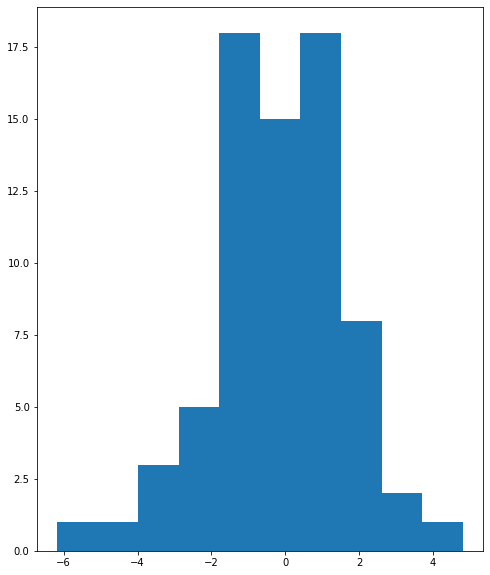

In [44]:
plt.hist((diff)/1000000)

In [45]:
len(diff[abs(diff)<500000])

16

In [46]:
from sklearn.tree import DecisionTreeRegressor

dtree=DecisionTreeRegressor()
#dtree.fit(X2_train,y2_train)
dtree.fit(X_train,y_train)

#diff=dtree.predict(X2_test)-y2_test
diff=np.exp(dtree.predict(X_test))-np.exp(y_test)
diff=diff.sort_values()
diff=diff.reset_index(drop=True)

(array([ 3.,  2.,  8., 12., 16., 18.,  4.,  4.,  4.,  1.]),
 array([-3908333. , -3067499.7, -2226666.4, -1385833.1,  -544999.8,
          295833.5,  1136666.8,  1977500.1,  2818333.4,  3659166.7,
         4500000. ]),
 <a list of 10 Patch objects>)

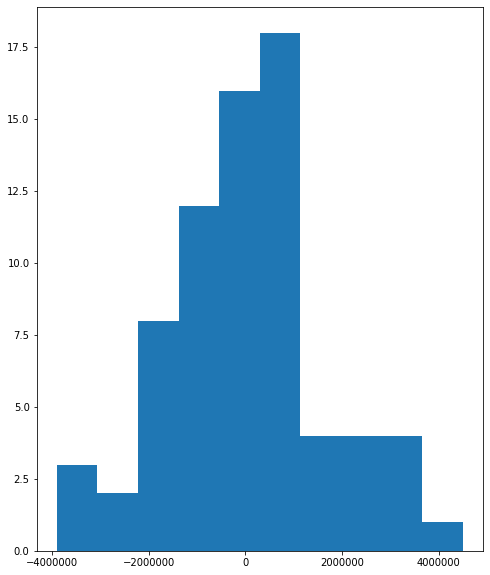

In [47]:
plt.hist(diff)

In [48]:
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-2500000.0000000093
99999.99999999814
2999999.9999999963
19


In [49]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf')
svr.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [50]:
diff=np.exp(svr.predict(X_test))-np.exp(y_test)
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
sum(diff)/len(y_test)

12026.503909712392

In [51]:
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-4666982.404901071
168007.0684864032
3084746.0386316907
20


In [52]:
len(diff[abs(diff)<500000])/len(diff)

0.2777777777777778

In [53]:
from sklearn.linear_model import SGDRegressor

sgd=SGDRegressor(max_iter=1000, tol=1e-3)
sgd.fit(X_train,y_train)
sgd.score(X_test,y_test)

-0.012726648566537158

In [54]:
diff=np.exp(sgd.predict(X_test))-np.exp(y_test)
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
sum(diff)/len(y_test)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-5090380.113538731
-180408.17911669426
2779783.999543506
15


In [55]:
from sklearn.ensemble import BaggingRegressor

model = BaggingRegressor()
model.fit(X_train,y_train)

diff=np.exp(model.predict(X_test))-np.exp(y_test)
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

print(model.score(X_test,y_test))

-3007566.026977264
-13052.85995892901
1878387.7786123576
19
0.5276643749273362


(array([ 2.,  2.,  4.,  6.,  9., 17., 16.,  9.,  5.,  2.]),
 array([-4176927.50249069, -3446159.07673696, -2715390.65098323,
        -1984622.22522951, -1253853.79947578,  -523085.37372205,
          207683.05203167,   938451.4777854 ,  1669219.90353913,
         2399988.32929285,  3130756.75504658]),
 <a list of 10 Patch objects>)

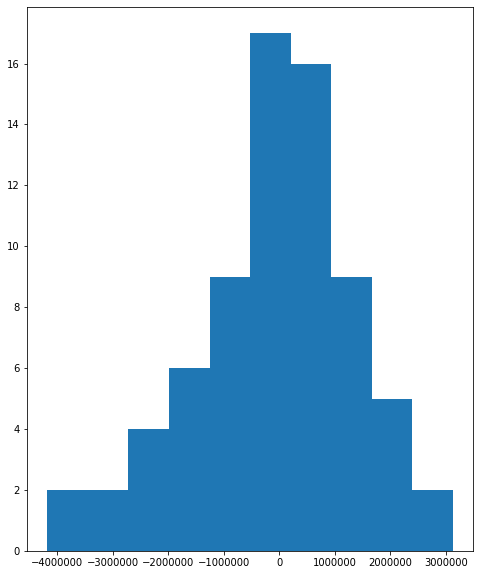

In [56]:
plt.hist(diff)

In [57]:
np.std(diff)

1470940.0004432285

In [58]:
model = BaggingRegressor()
model.fit(X2_train,y2_train)

diff=np.exp(model.predict(X2_test))-np.exp(y2_test)
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

print(model.score(X2_test,y2_test))

-3307909.106126963
-98485.63534409506
2337306.7873027646
18
0.39031059448857314


(array([ 4.,  3.,  7.,  9., 12., 13., 13.,  5.,  4.,  2.]),
 array([-3741950.55658773, -3035349.50876864, -2328748.46094954,
        -1622147.41313045,  -915546.36531135,  -208945.31749226,
          497655.73032684,  1204256.77814593,  1910857.82596503,
         2617458.87378412,  3324059.92160321]),
 <a list of 10 Patch objects>)

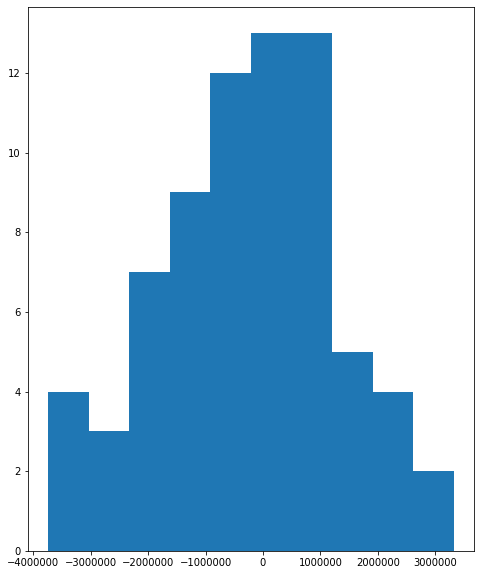

In [60]:
plt.hist(diff)
#savefig('sample.pdf')

In [61]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(random_state=1, max_iter=1000000).fit(X_train, y_train)
regr.predict(X_test)
regr.score(X_test, y_test)

0.005761689487356225

In [62]:
diff=np.exp(regr.predict(X_test))-np.exp(y_test)
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-5539155.758280339
-478148.1170381536
2430855.911009703
13
